In [81]:
from astropy.io import fits
import numpy as np
import numpy as np
import pandas as pd
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import warnings
import pickle
from extreme_deconvolution import extreme_deconvolution
from scipy.linalg import det 
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014

warnings.filterwarnings("ignore", category=FutureWarning)

# File path
filtered_corrected_galpy_data = 'data/Allsky_Gaia_8910601_rv_extinction_corrected_filtered_galpy.fits'

## The best results from this are at the end of the notebook


# During the preprocessing we used galpy to obtain orbital parameter - try and use these in a similiar approach 
## Energy, Lz and R_gal

# Method 1: Retry Clustering by Binning (4d Historgam)
## I adjust this many times, couldnt get good results

In [3]:
with fits.open(filtered_corrected_galpy_data, memmap=True) as hdul:
    stream_data = hdul[1].data
    stream_df = Table(stream_data).to_pandas()
    l = stream_df['l']
    b = stream_df['b']
    energy = stream_df['energy']
    Lz = stream_df['Lz']
    R_gal = stream_df['R_gal']

# Remove stars with R < 1 kpc
stream_df = stream_df[R_gal >2]
l = stream_df['l']
b = stream_df['b']
energy = stream_df['energy']
Lz = stream_df['Lz']
R_gal = stream_df['R_gal']


In [4]:
display(stream_df.describe())

,source_id,l,b,ra,dec,ra_error,dec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,...,r_hi_photogeo,r_lo_photogeo,dered_G,dered_BP,dered_RP,dered_BP_RP,M_G,energy,Lz,R_gal
count,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,...,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06
mean,4.343797e+18,1.837335e+02,-9.459711e-01,2.258956e+02,-1.681869e+01,1.880051e-02,1.738173e-02,1.445456e+01,1.543461e+01,1.350958e+01,...,5.528049e+03,4.435312e+03,1.339232e+01,1.390468e+01,1.260334e+01,1.301343e+00,4.055386e-02,-5.745670e+04,1.251454e+03,6.757426e+00
std,1.693791e+18,1.306440e+02,1.193433e+01,7.888563e+01,3.791089e+01,8.018817e-03,6.414487e-03,7.619720e-01,9.435168e-01,7.364850e-01,...,2.249807e+03,1.462621e+03,8.312038e-01,9.148638e-01,8.927022e-01,2.701550e-01,9.213969e-01,2.367107e+04,7.420915e+02,3.007537e+00
min,9.009553e+13,7.374925e-05,-8.969809e+01,6.117030e-04,-8.996995e+01,3.945457e-03,4.656644e-03,1.000015e+01,1.053315e+01,8.611038e+00,...,1.693511e+03,8.751464e+02,6.599596e+00,6.292698e+00,5.780555e+00,5.000029e-01,-9.204772e+00,-1.292145e+05,-8.711174e+03,2.000001e+00
25%,3.418265e+18,4.697036e+01,-6.982882e+00,1.728346e+02,-4.950756e+01,1.309325e-02,1.294093e-02,1.402488e+01,1.484709e+01,1.312463e+01,...,3.981171e+03,3.419286e+03,1.292607e+01,1.342088e+01,1.210133e+01,1.138027e+00,-5.408297e-01,-7.369442e+04,7.042663e+02,4.492904e+00
50%,4.314505e+18,2.038350e+02,-2.636230e+00,2.564047e+02,-2.282593e+01,1.721662e-02,1.623385e-02,1.458911e+01,1.544150e+01,1.368153e+01,...,4.976705e+03,4.108673e+03,1.351829e+01,1.406656e+01,1.274053e+01,1.272947e+00,2.601786e-01,-5.560048e+04,1.178342e+03,6.113160e+00
75%,5.858346e+18,3.132719e+02,5.606293e+00,2.828485e+02,1.130025e+01,2.294823e-02,2.033336e-02,1.499948e+01,1.601863e+01,1.406900e+01,...,6.370588e+03,5.017613e+03,1.401174e+01,1.457885e+01,1.326890e+01,1.467030e+00,6.749306e-01,-3.802143e+04,1.788578e+03,8.885597e+00
max,6.917527e+18,3.600000e+02,8.993158e+01,3.599999e+02,8.990038e+01,2.963450e-01,3.878340e-01,1.806356e+01,2.036324e+01,1.755235e+01,...,1.027068e+05,4.489459e+04,1.786672e+01,1.803785e+01,1.741093e+01,1.999999e+00,3.814045e+00,5.251557e+05,2.166994e+04,5.318119e+01


In [ ]:
# Define bin sizes of scanning
l_b_bin_width = 2 # Galactic Longitude/Latitude bin width (±16
Energy_width = 1000  # Energy bin width
Lz_width =3000      # Lz bin width
R_gal_width = 5 # R_gal bin width
threshold = 0.1  # Threshold for filtering PM bins

# Identify bin centers -- Proper non-overlapping spacing
l_centers = np.arange(min(l) + l_b_bin_width / 2, max(l), l_b_bin_width)
b_centers = np.arange(min(b) + l_b_bin_width / 2, max(b), l_b_bin_width)
Lz_centers = np.arange(min(Lz) + Lz_width / 2, max(Lz), Lz_width)
R_gal_centers = np.arange(min(R_gal) + R_gal_width / 2, max(R_gal), R_gal_width)

# Compute edges correctly from centers (proper non-overlapping bins)
l_edges = np.arange(min(l), max(l) + l_b_bin_width, l_b_bin_width)
b_edges = np.arange(min(b), max(b) + l_b_bin_width, l_b_bin_width)
Lz_edges = np.arange(min(Lz), max(Lz) + Lz_width, Lz_width)
R_gal_edges = np.arange(min(R_gal), max(R_gal) + R_gal_width, R_gal_width)

# 4D Histogram: Galactic Longitude, Latitude, PM_RA, PM_DEC
hist_4d, edges_4d = np.histogramdd((l, b, Lz, R_gal), bins=[l_edges, b_edges, Lz_edges, R_gal_edges])

# 2D Histogram: Total sum of stars in each (l, b) bin from collapsed 4D
hist_2d = np.sum(hist_4d, axis=(2,3))

# Filter PM bins where sum is ≥ threshold% of the corresponding 2D bin
mask = (hist_4d >= threshold * hist_2d[:,:,None,None]) & (hist_4d > 20)
filtered_4d_hist = np.where(mask, hist_4d, 0)


# Total number of bins in the 4D histogram and number of non-empty bins
total_bins = filtered_4d_hist.size
nonzero_bins = np.count_nonzero(filtered_4d_hist)

# Collapse PM_RA and PM_DEC to get a 2D histogram in (l, b)
filtered_2d_hist = np.sum(filtered_4d_hist, axis=(2,3))
# Total number of (l, b) bins and non-zero bins
total_bins_2d = filtered_2d_hist.size
nonzero_bins_2d = np.count_nonzero(filtered_2d_hist)

# Print results
print(f"Total number of 4D bins: {total_bins}")
print(f"Number of nonzero 4D bins: {nonzero_bins}")
print(f"Total number of (l, b) 2D bins: {total_bins_2d}")
print(f"Number of nonzero (l, b) 2D bins: {nonzero_bins_2d}")


Total number of 4D bins: 1960200
Number of nonzero 4D bins: 10417
Total number of (l, b) 2D bins: 16200
Number of nonzero (l, b) 2D bins: 7046


In [26]:
# Cluster stars in adjacent 4D Bin
nonzero_mask = filtered_4d_hist > 0

# Define a strict 4D connectivity structure (ensuring adjacency in all 4D dimensions)
structure = generate_binary_structure(rank=4, connectivity=1)

# Apply labeling to identify distinct clusters
labeled_array, num_features = label(nonzero_mask, structure=structure)

# Store cluster Galactic Longitude, Latitude, and Proper Motion ranges
cluster_ranges = []

# Loop through each cluster ID with tqdm for progress tracking
for i in tqdm(range(1, num_features + 1), desc="Processing Clusters"):  # Cluster labels start from 1
    indices = np.argwhere(labeled_array == i)  # Get all (L, B, PM_RA, PM_DEC) indices for cluster

    # Extract corresponding Galactic Longitude and Latitude bin edges
    l_min = l_edges[min(indices[:, 0])]  # Min L bin edge
    l_max = l_edges[max(indices[:, 0]) + 1]  # Max L bin edge (next bin's start)
    b_min = b_edges[min(indices[:, 1])]  # Min B bin edge
    b_max = b_edges[max(indices[:, 1]) + 1]  # Max B bin edge (next bin's start)


    # Extract corresponding Lz bin edges
    Lz_min = Lz_edges[min(indices[:, 2])]  # Min Lz bin edge
    Lz_max = Lz_edges[max(indices[:, 2]) + 1]  # Max Lz bin edge (next bin's start)

    # Extract corresponding R_gal bin edges
    R_gal_min = R_gal_edges[min(indices[:, 3])]  # Min R_gal bin edge
    R_gal_max = R_gal_edges[max(indices[:, 3]) + 1]  # Max R_gal bin edge (next bin's start)

    # Store results
    cluster_ranges.append([i, l_min, l_max, b_min, b_max, Lz_min, Lz_max, R_gal_min, R_gal_max])

Processing Clusters: 100%|██████████| 60/60 [00:00<00:00, 213.94it/s]


In [24]:
# Identify clusters that are fully contained within another cluster
clusters_to_remove = set()

for i, cluster_outer in enumerate(cluster_ranges):
    cluster_id_outer, l_min_outer, l_max_outer, b_min_outer, b_max_outer, Lz_min_outer, Lz_max_outer, R_gal_min_outer, R_gal_max_outer = cluster_outer

    for j, cluster_inner in enumerate(cluster_ranges):
        if i == j:  # Skip self-comparison
            continue

        cluster_id_inner, l_min_inner, l_max_inner, b_min_inner, b_max_inner, Lz_min_inner, Lz_max_inner, R_gal_min_inner, R_gal_max_inner = cluster_inner

        # Check if inner cluster is fully contained within outer cluster
        if (l_min_outer <= l_min_inner <= l_max_inner <= l_max_outer) and \
           (b_min_outer <= b_min_inner <= b_max_inner <= b_max_outer) and \
           (Lz_min_outer <= Lz_min_inner <= Lz_max_inner <= Lz_max_outer) and \
           (R_gal_min_outer <= R_gal_min_inner <= R_gal_max_inner <= R_gal_max_outer):
            clusters_to_remove.add(j)  # Mark the inner cluster for removal

# Remove fully contained clusters
cluster_ranges = [cluster for i, cluster in enumerate(cluster_ranges) if i not in clusters_to_remove]

# Print the number of removed clusters
print(f"Removed {len(clusters_to_remove)} fully contained clusters.")

Removed 52 fully contained clusters.


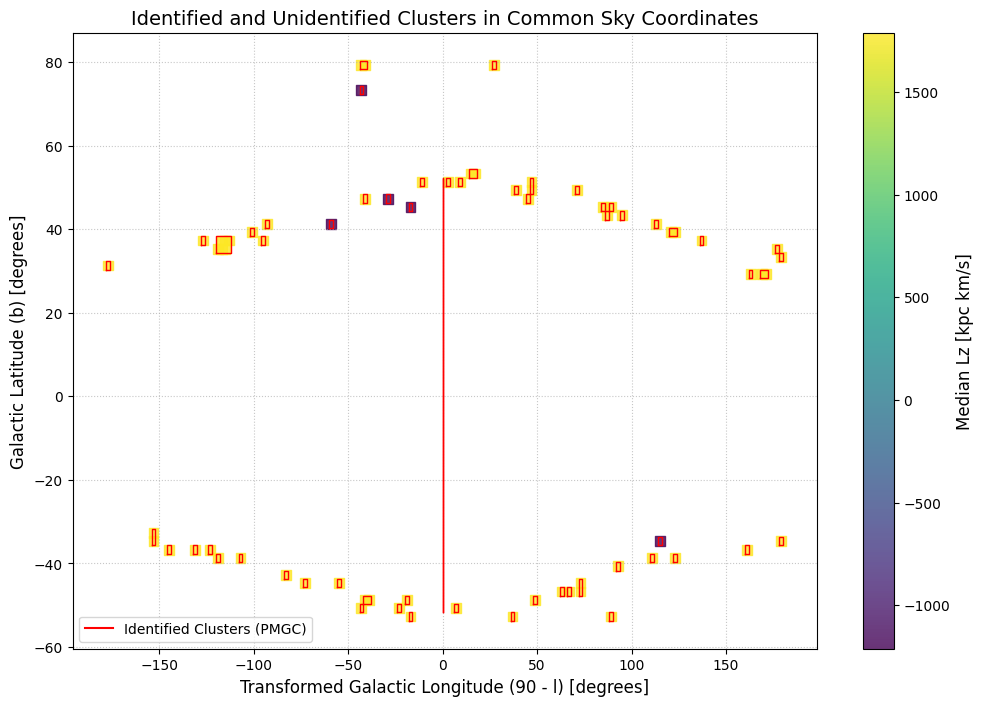

In [27]:

# Function to transform Galactic Longitude (l) to common sky coordinates
def transform_l(l_values):
    transformed = -l_values  # Convert l to -l
    transformed = (transformed + 180) % 360 - 180  # Wrap to [-180, 180] range
    return transformed

# Identify occupied L-B bins from filtered 2D histogram
occupied_l_b = np.argwhere(filtered_2d_hist > 0)

# Convert indices to Galactic Longitude (L) and Latitude (B) centers
l_occupied = transform_l(l_centers[occupied_l_b[:, 0]])  # Apply transformation
b_occupied = b_centers[occupied_l_b[:, 1]]  # Latitude remains the same

# Assign each occupied bin to a cluster's median Lz
Lz_med_values = np.full(len(l_occupied), np.nan)  # Initialize array to store median Lz per occupied bin

for cluster in cluster_ranges:
    cluster_id, l_min, l_max, b_min, b_max, Lz_min, Lz_max, R_gal_min, R_gal_max= cluster[:9]  # Extract relevant cluster info

    # Transform l_min and l_max
    l_min_transformed = transform_l(l_min)
    l_max_transformed = transform_l(l_max)
    Lz_med = (Lz_min + Lz_max) / 2  # Compute median Lz
    R_gal_med = (R_gal_min + R_gal_max) / 2  # Compute median R_gal

    # Ensure correct ordering for box plotting (min should be left, max should be right)
    if l_min_transformed > l_max_transformed:
        l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

    # Skip extreme wrap-around cases
    if abs(l_min_transformed - l_max_transformed) > 100:
        continue

    # Assign Lz_med to points inside the cluster box
    inside_cluster = (l_occupied >= l_min_transformed) & (l_occupied <= l_max_transformed) & \
                     (b_occupied >= b_min) & (b_occupied <= b_max)
    
    Lz_med_values[inside_cluster] = Lz_med  # Assign median Lz to corresponding points

# Plot scatter plot with color-coded Lz_med
plt.figure(figsize=(12, 8))

# Scatter plot where color represents median Lz of the cluster the point is inside
sc = plt.scatter(l_occupied, b_occupied, marker='s', s=50, alpha=0.8, c=Lz_med_values, cmap='viridis')

# Labels and formatting
plt.xlabel("Transformed Galactic Longitude (90 - l) [degrees]", fontsize=12)
plt.ylabel("Galactic Latitude (b) [degrees]", fontsize=12)
plt.title("Identified and Unidentified Clusters in Common Sky Coordinates", fontsize=14)

# Add cluster boxes
for cluster in cluster_ranges:
    cluster_id, l_min, l_max, b_min, b_max, Lz_min, Lz_max = cluster[:7]

    # Transform l_min and l_max
    l_min_transformed = transform_l(l_min)
    l_max_transformed = transform_l(l_max)

    if l_min_transformed > l_max_transformed:
        l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

    if abs(l_min_transformed - l_max_transformed) > 100:
        continue

    # Draw cluster box
    plt.plot(
        [l_min_transformed, l_max_transformed, l_max_transformed, l_min_transformed, l_min_transformed],
        [b_min, b_min, b_max, b_max, b_min],
        '-', color='red', linewidth=1
    )

# Add colorbar for Lz_med
cbar = plt.colorbar(sc)
cbar.set_label("Median Lz [kpc km/s]", fontsize=12)

# Custom legend
plt.plot([], [], 'r-', label="Identified Clusters (PMGC)")
plt.legend(fontsize=10, loc="lower left")

plt.grid(True, linestyle=":", alpha=0.7)  # Light dotted grid for clarity
plt.show()

# Method 2: HBDSCAN

In [31]:
import hdbscan
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [58]:
def run_hdbscan(df_part, keys, min_cluster_size=40, min_samples=15, use_leaf=True):
    """
    Run HDBSCAN clustering on selected columns of a DataFrame.

    Parameters
    ----------
    df_part : pd.DataFrame
        The input DataFrame containing the data to be clustered.

    keys : list of str
        The column names in `df_part` to use as features for clustering (e.g. ['l', 'b', 'pmra', 'pmdec']).

    min_cluster_size : int, optional (default=40)
        The minimum number of samples in a cluster. Smaller clusters are considered noise.

    min_samples : int, optional (default=15)
        The number of samples in a neighborhood for a point to be considered a core point.
        Higher values make the algorithm more conservative.

    use_leaf : bool, optional (default=True)
        Whether to use 'leaf' method (finer sub-cluster selection) or 'eom' (excess of mass) method
        for selecting clusters.

    Returns
    -------
    df_part : pd.DataFrame
        The original DataFrame with an added column 'cluster', containing cluster labels.
        Points with label -1 are considered noise (not part of any cluster).

    Notes
    -----
    - This function uses HDBSCAN, a density-based clustering algorithm that can find clusters
      of varying densities and label noise points.
    - Features are standardized before clustering using `StandardScaler`.
    """
    X = df_part[keys].values
    X_scaled = StandardScaler().fit_transform(X)
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_method='leaf' if use_leaf else 'eom',
        core_dist_n_jobs=-1
    )
    df_part['cluster'] = clusterer.fit_predict(X_scaled)
    return df_part

In [59]:
def remove_plane_edge_clusters(df):
    """
    Removes clusters that contain both:
    - At least one star with |b| < 15 (near Galactic plane)
    - AND at least one star with |l| > 30 (away from Galactic center)

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns 'l', 'b', and 'cluster' (output of run_hdbscan).

    Returns
    -------
    df_filtered : pd.DataFrame
        Filtered DataFrame with unwanted clusters removed.
    """
    df = df.copy()
    valid_clusters = []

    # Loop through all unique clusters (excluding noise)
    for cluster_id in df['cluster'].unique():
        if cluster_id == -1:
            continue  # skip noise

        cluster_df = df[df['cluster'] == cluster_id]

        has_near_plane = np.any(np.abs(cluster_df['b']) < 15)
        has_far_from_center = np.any(np.abs(cluster_df['l']) > 30)

        # If the cluster doesn't satisfy both conditions, keep it
        if not (has_near_plane and has_far_from_center):
            valid_clusters.append(cluster_id)

    # Keep only the valid clusters and noise
    mask = df['cluster'].isin(valid_clusters) | (df['cluster'] == -1)
    return df[mask]

In [ ]:

def plot_hdbscan_clusters_mollweide(results_df, title):
    """
    Plot the results of HDBSCAN clustering in Galactic coordinates using a Mollweide projection.

    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame containing 'l', 'b', and 'cluster' columns.
    title : str
        Title to display above the plot.
    """
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection='mollweide')

    # Convert Galactic longitude for Mollweide
    l = results_df['l'].values
    b = results_df['b'].values
    l_transformed = (l + 180) % 360 - 180
    l_transformed = -l_transformed
    l_rad = np.radians(l_transformed)
    b_rad = np.radians(b)

    results_df = results_df.copy()
    results_df['l_rad'] = l_rad
    results_df['b_rad'] = b_rad

    clustered = results_df[results_df['cluster'] != -1]
    noise = results_df[results_df['cluster'] == -1]

    # Plot noise as dark grey
    ax.scatter(noise['l_rad'], noise['b_rad'], s=3, color='dimgrey', alpha=0.4)

    # Get a perceptually uniform colormap (darker)
    unique_clusters = sorted(clustered['cluster'].unique())
    colors = cm.inferno(np.linspace(0.1, 0.9, len(unique_clusters)))  # Use inferno, adjust range

    # Plot clusters
    for color, cluster_id in zip(colors, unique_clusters):
        cluster_data = clustered[clustered['cluster'] == cluster_id]
        ax.scatter(cluster_data['l_rad'], cluster_data['b_rad'], s=6, color=color, alpha=0.8)

    # Axis and formatting (darker grid, thicker lines)
    ax.set_title(f"HDBSCAN Clusters by {title}", fontsize=16, pad=20)
    ax.grid(True, linestyle='-', color='darkgrey', alpha=0.5, linewidth=0.8) #darker grid

    # Longitude ticks (l)
    tick_labels = ["150°", "120°", "90°", "60°", "30°", "0°", "-30°", "-60°", "-90°", "-120°", "-150°"]
    tick_positions = np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Set background color to a very light grey
    ax.set_facecolor('0.95') # Very light grey
    fig.patch.set_facecolor('0.95') #make the figure background the same light grey.

    plt.tight_layout()
    plt.show()

## Trying with simple l,b and proper motion parameters (an galpy dataset)

In [65]:
with fits.open(filtered_corrected_galpy_data, memmap=True) as hdul:
    stream_data = hdul[1].data
    stream_df = Table(stream_data).to_pandas()

# Remove stars with abs(b) < 10
stream_df = stream_df[abs(stream_df['b']) > 10]
stream_df['pm'] = np.sqrt(stream_df['pmra']**2 + stream_df['pmdec']**2)

In [41]:
display(stream_df.describe())

,source_id,l,b,ra,dec,ra_error,dec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,...,r_hi_photogeo,r_lo_photogeo,dered_G,dered_BP,dered_RP,dered_BP_RP,M_G,energy,Lz,R_gal
count,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,...,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06,1.952892e+06
mean,4.507693e+18,1.806326e+02,-1.642111e+00,2.273168e+02,-1.566818e+01,1.651202e-02,1.474127e-02,1.412994e+01,1.481966e+01,1.333487e+01,...,5.705040e+03,4.666570e+03,1.373498e+01,1.430116e+01,1.301630e+01,1.284852e+00,3.131998e-01,-5.783674e+04,1.044554e+03,6.537503e+00
std,1.867104e+18,1.336408e+02,2.067550e+01,8.270308e+01,3.728440e+01,5.643229e-03,4.313155e-03,7.409414e-01,7.466049e-01,7.582613e-01,...,2.661227e+03,1.758631e+03,7.229335e-01,6.839206e-01,7.660690e-01,2.074982e-01,8.934112e-01,2.345666e+04,7.950675e+02,3.243066e+00
min,9.009553e+13,1.230476e-04,-8.969809e+01,6.117030e-04,-8.996995e+01,3.993523e-03,4.656644e-03,1.000729e+01,1.053315e+01,9.036088e+00,...,1.693511e+03,8.751464e+02,8.083518e+00,7.733585e+00,7.054504e+00,5.000277e-01,-9.204772e+00,-1.261090e+05,-8.711174e+03,3.025914e-03
25%,3.390064e+18,4.070057e+01,-1.525230e+01,1.805587e+02,-4.291115e+01,1.227070e-02,1.153718e-02,1.370800e+01,1.436799e+01,1.292488e+01,...,3.986696e+03,3.479281e+03,1.332644e+01,1.389252e+01,1.260399e+01,1.145543e+00,-1.868551e-01,-7.376685e+04,4.676630e+02,4.245195e+00
50%,4.538544e+18,1.861373e+02,-1.058966e+01,2.589247e+02,-2.207571e+01,1.579126e-02,1.413969e-02,1.427137e+01,1.491875e+01,1.349615e+01,...,5.080987e+03,4.265050e+03,1.386189e+01,1.440729e+01,1.315777e+01,1.238011e+00,5.140028e-01,-5.705864e+04,9.554561e+02,5.771593e+00
75%,6.035448e+18,3.184092e+02,1.381216e+01,2.846423e+02,9.684050e+00,2.021842e-02,1.727585e-02,1.469395e+01,1.534209e+01,1.392483e+01,...,6.536836e+03,5.337536e+03,1.428783e+01,1.482041e+01,1.360019e+01,1.387901e+00,8.063335e-01,-3.904616e+04,1.547808e+03,8.730421e+00
max,6.917527e+18,3.599999e+02,8.993158e+01,3.599985e+02,8.990038e+01,2.133820e-01,2.297182e-01,1.806356e+01,1.907225e+01,1.755235e+01,...,1.027068e+05,4.489459e+04,1.786672e+01,1.803785e+01,1.741093e+01,1.999995e+00,3.814045e+00,4.171357e+05,2.166994e+04,5.318119e+01


In [56]:
results_l_b_pmra_pmdec = run_hdbscan(stream_df, keys=['l', 'b', 'pmra', 'pmdec'], min_cluster_size=40, min_samples=15)

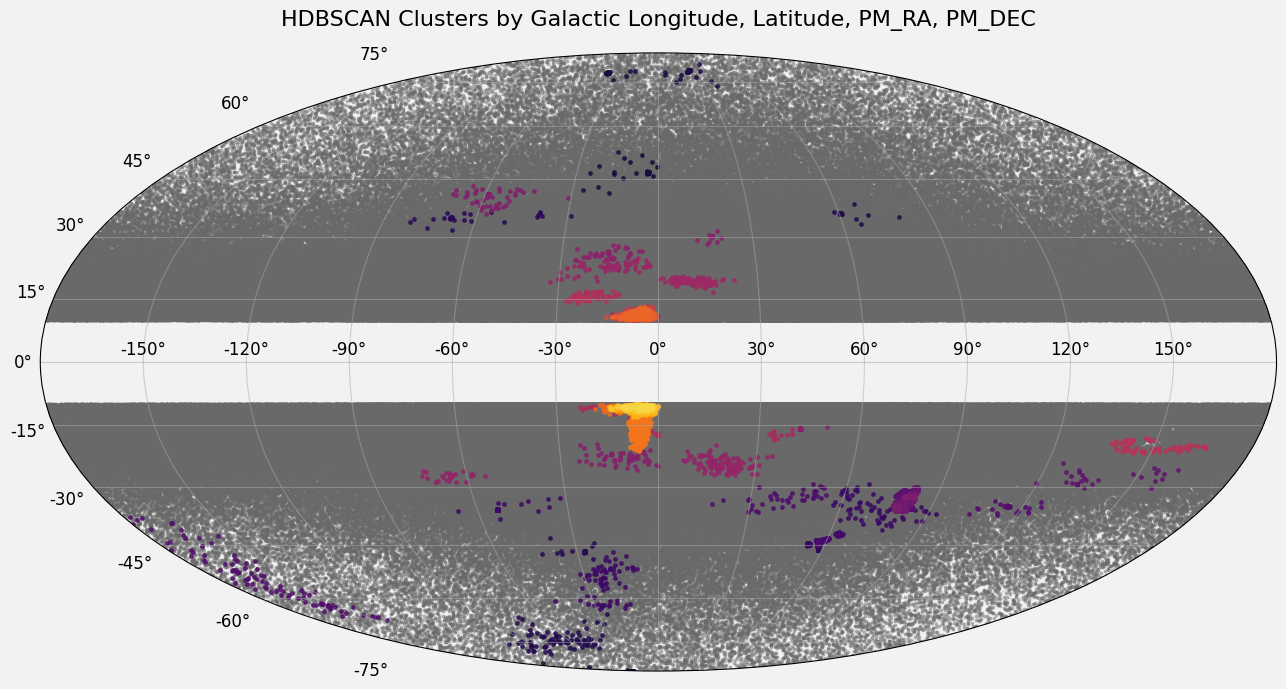

In [ ]:
results_l_b_pmra_pmdec_filt = remove_plane_edge_clusters(results_l_b_pmra_pmdec)
plot_hdbscan_clusters_mollweide(results_l_b_pmra_pmdec_filt, title="Galactic Longitude, Latitude, Proper Motion Ra and Dec")

## Try with orbital parameters in Energy and Lz

In [94]:
results_l_b_energy_Lz = run_hdbscan(stream_df, keys=['l', 'b', 'energy', 'Lz'], min_cluster_size=40, min_samples=15)

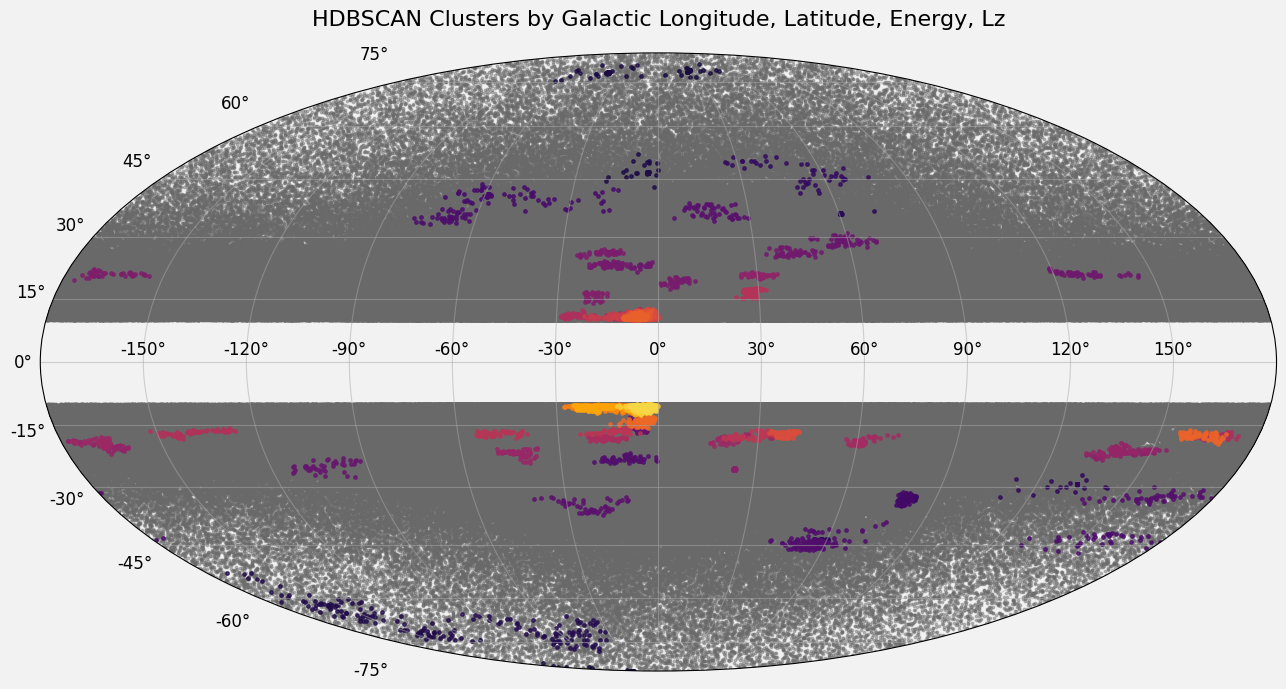

In [95]:
results_l_b_energy_Lz_filt = remove_plane_edge_clusters(results_l_b_energy_Lz)
plot_hdbscan_clusters_mollweide(results_l_b_energy_Lz_filt, title="Galactic Longitude, Latitude, Energy, Lz")

## Try with Galocentric Radius

In [96]:
results_l_b_pm_Rgal = run_hdbscan(stream_df, keys=['l', 'b', 'pm', 'R_gal'], min_cluster_size=40, min_samples=15)

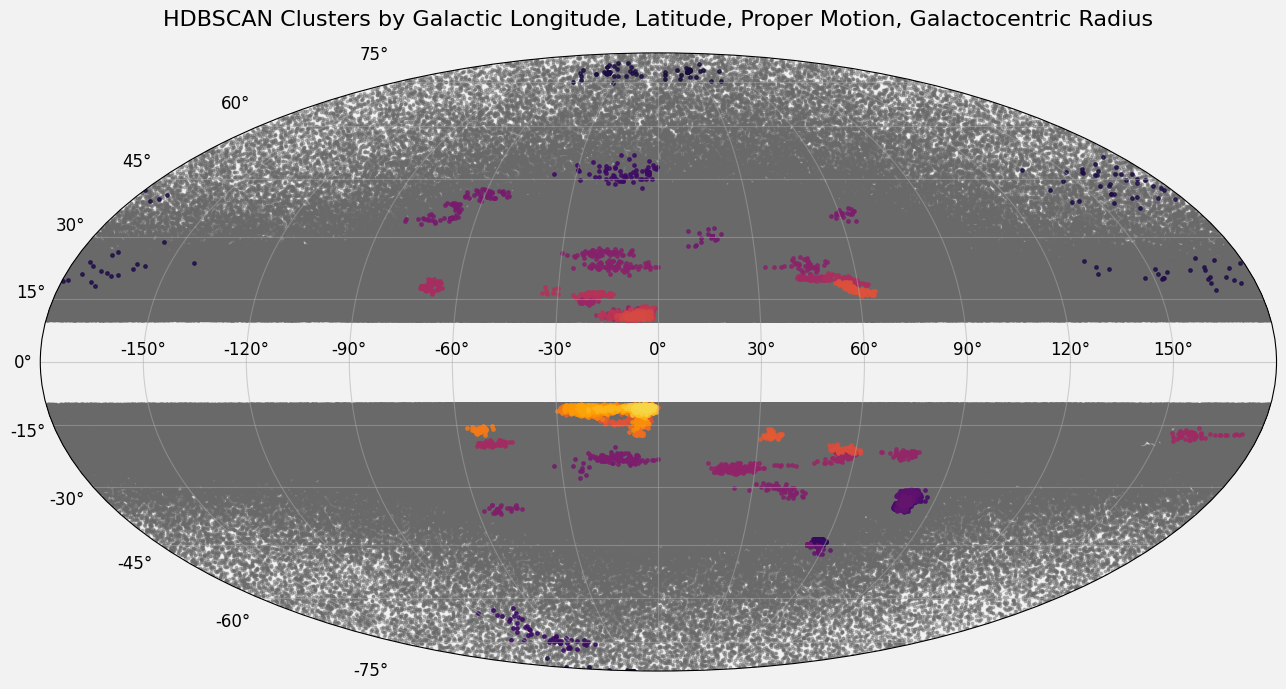

In [97]:
results_l_b_pm_Rgal_filt = remove_plane_edge_clusters(results_l_b_pm_Rgal)
plot_hdbscan_clusters_mollweide(results_l_b_pm_Rgal_filt, title="Galactic Longitude, Latitude, Proper Motion, Galactocentric Radius")

## Investigate on Larger (Non Radial Velocity Data)

In [100]:
# File path
rgb_data_path = 'data/Allsky_Gaia_42481846_extinction_corrected_filtered.fits'

# Load the FITS file with data used in this analysis
with fits.open(rgb_data_path, memmap=True) as hdul:
    data = hdul[1].data 
    ra = data['ra']
    dec = data['dec']
    l = data['l']
    b = data['b']
    dered_G = data['dered_G']
    dered_BP_RP = data['dered_BP_RP']
    pm = (data['pmra'] **2 + data['pmdec'] **2)**(1/2)
    pmra = data['pmra']
    pmdec = data['pmdec']

# -------------------------------
# Additional filter: color + magnitude
# -------------------------------
mag_bins = [14., 18.5]
w = (dered_BP_RP > 1.0) & (dered_G > mag_bins[0]) & (dered_G < mag_bins[1]) & (abs(b)>10)

# Apply to all relevant arrays
ra = ra[w]
dec = dec[w]
l = l[w]
b = b[w]
dered_G = dered_G[w]
dered_BP_RP = dered_BP_RP[w]
pm = pm[w]

# -------------------------------
# All-sky dataframe (Galactic)
# -------------------------------
all_sky = pd.DataFrame({
    'l': l,
    'b': b,
    'dered_G': dered_G,
    'ra': ra,
    'dec': dec,
    'dered_G': dered_G,
    'dered_BP_RP': dered_BP_RP,
    'pm': pm,
    'pmra': pmra[w],
    'pmdec': pmdec[w]
})

display(all_sky.describe())

,l,b,dered_G,ra,dec,dered_BP_RP,pm,pmra,pmdec
count,1.853458e+06,1.853458e+06,1.853458e+06,1.853458e+06,1.853458e+06,1.853458e+06,1.853458e+06,1.853458e+06,1.853458e+06
mean,2.040599e+02,-1.446070e+01,1.653183e+01,1.615118e+02,-3.288319e+01,1.244017e+00,2.176167e+00,4.710963e-02,-6.619047e-01
std,1.173751e+02,2.430411e+01,9.452525e-01,1.028827e+02,4.189169e+01,2.454962e-01,8.521127e-01,1.737229e+00,1.415450e+00
min,1.377289e-04,-8.986854e+01,1.400004e+01,2.892102e-05,-8.986697e+01,1.000002e+00,2.283908e-03,-3.999010e+00,-3.999927e+00
25%,8.492094e+01,-3.302123e+01,1.586960e+01,7.898297e+01,-6.947791e+01,1.083069e+00,1.636397e+00,-1.417419e+00,-1.583656e+00
50%,2.754779e+02,-1.875794e+01,1.667523e+01,1.075590e+02,-4.054786e+01,1.176352e+00,2.013120e+00,3.476932e-01,-4.837111e-01
75%,2.832693e+02,1.063150e+01,1.731781e+01,2.711860e+02,-8.631135e+00,1.325817e+00,2.847289e+00,1.699029e+00,3.878056e-01
max,3.600000e+02,8.968736e+01,1.800000e+01,3.599999e+02,8.982905e+01,4.809336e+00,3.999998e+00,3.999802e+00,3.997814e+00


In [ ]:
results_nonrv = run_hdbscan(all_sky, keys=['l', 'b', 'pmra', 'pmdec'], min_cluster_size=40, min_samples=15)

In [109]:
results_nonrv_filt = remove_plane_edge_clusters(results_nonrv)

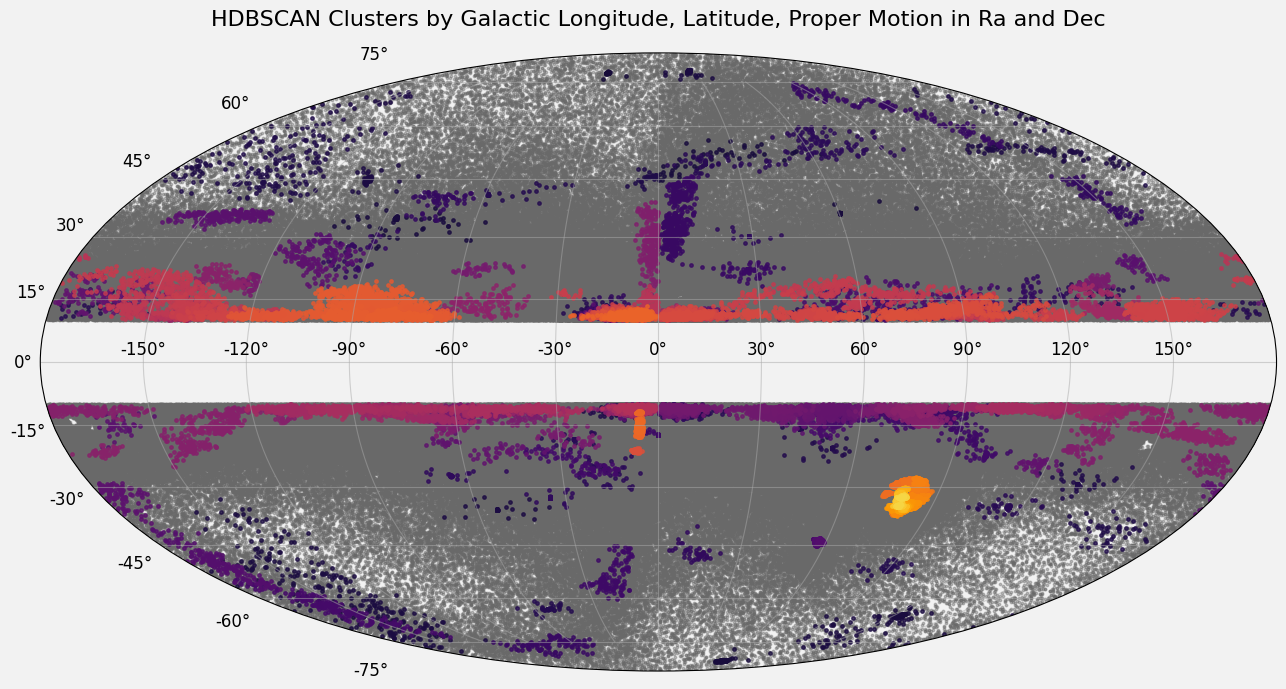

In [108]:
plot_hdbscan_clusters_mollweide(results_nonrv, title="Galactic Longitude, Latitude, Proper Motion in Ra and Dec")

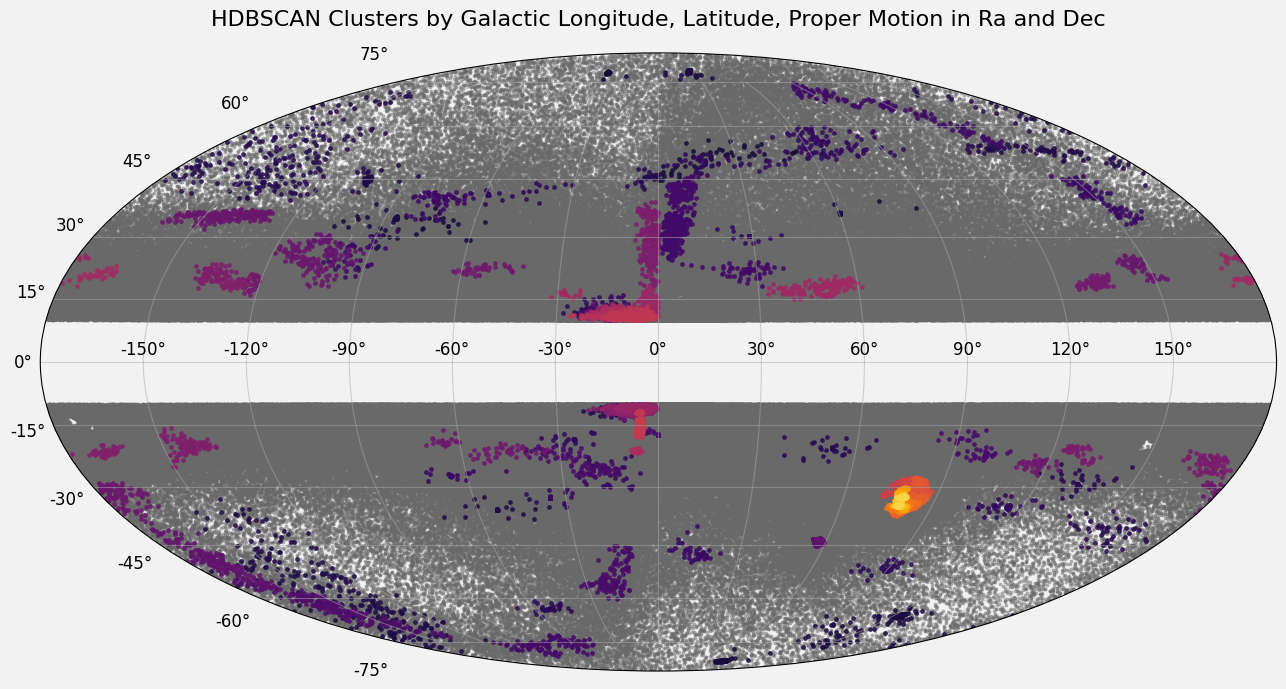

In [110]:
plot_hdbscan_clusters_mollweide(results_nonrv_filt, title="Galactic Longitude, Latitude, Proper Motion in Ra and Dec")